2025-07-22 19:47:20.939994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 19:47:20.940020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 19:47:20.940991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 19:47:20.948036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 19:47:21.971201: W tensorflow/compiler/tf2

Loaded images: left (200, 96, 96, 3), right (200, 96, 96, 3)

Training BCE model...
Epoch 1/5


2025-07-22 19:47:29.508166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-22 19:47:29.552127: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


5/5 - 2s - 473ms/step - accuracy: 0.9937 - loss: 0.3796 - val_accuracy: 1.0000 - val_loss: 0.2953
Epoch 2/5
5/5 - 1s - 222ms/step - accuracy: 1.0000 - loss: 0.2815 - val_accuracy: 1.0000 - val_loss: 0.2669
Epoch 3/5
5/5 - 1s - 283ms/step - accuracy: 1.0000 - loss: 0.2586 - val_accuracy: 1.0000 - val_loss: 0.2495
Epoch 4/5
5/5 - 1s - 229ms/step - accuracy: 1.0000 - loss: 0.2422 - val_accuracy: 1.0000 - val_loss: 0.2342
Epoch 5/5
5/5 - 1s - 262ms/step - accuracy: 1.0000 - loss: 0.2272 - val_accuracy: 1.0000 - val_loss: 0.2199

Training Contrastive model...
Epoch 1/5
5/5 - 2s - 444ms/step - loss: 0.0820 - val_loss: 0.0010
Epoch 2/5
5/5 - 1s - 253ms/step - loss: 9.9444e-04 - val_loss: 6.6595e-04
Epoch 3/5
5/5 - 1s - 237ms/step - loss: 6.5386e-04 - val_loss: 4.6934e-04
Epoch 4/5
5/5 - 1s - 220ms/step - loss: 4.8150e-04 - val_loss: 3.4370e-04
Epoch 5/5
5/5 - 1s - 238ms/step - loss: 3.7078e-04 - val_loss: 2.6124e-04

Training Triplet model...
Epoch 1/5
5/5 - 3s - 534ms/step - loss: 0.1891 - v

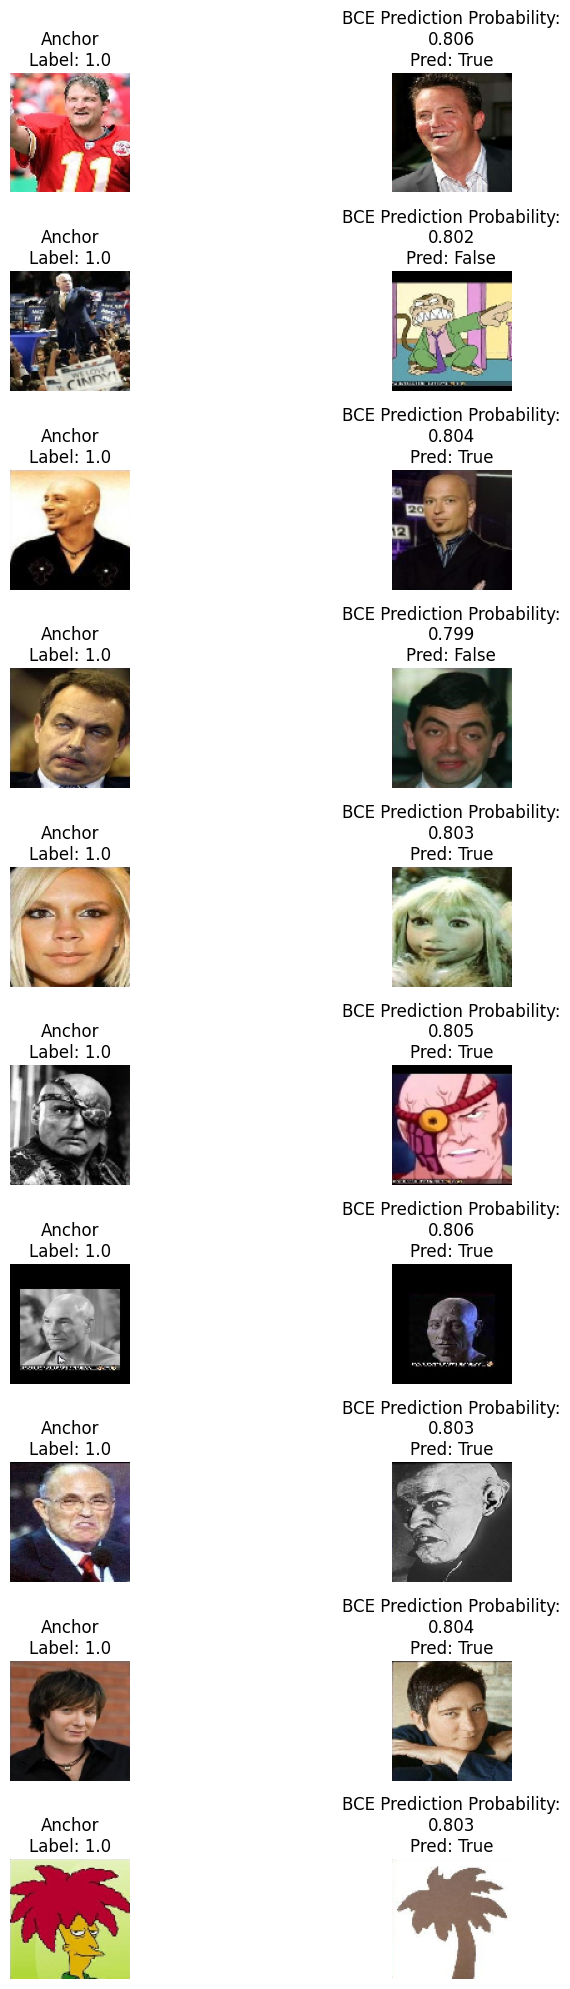

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


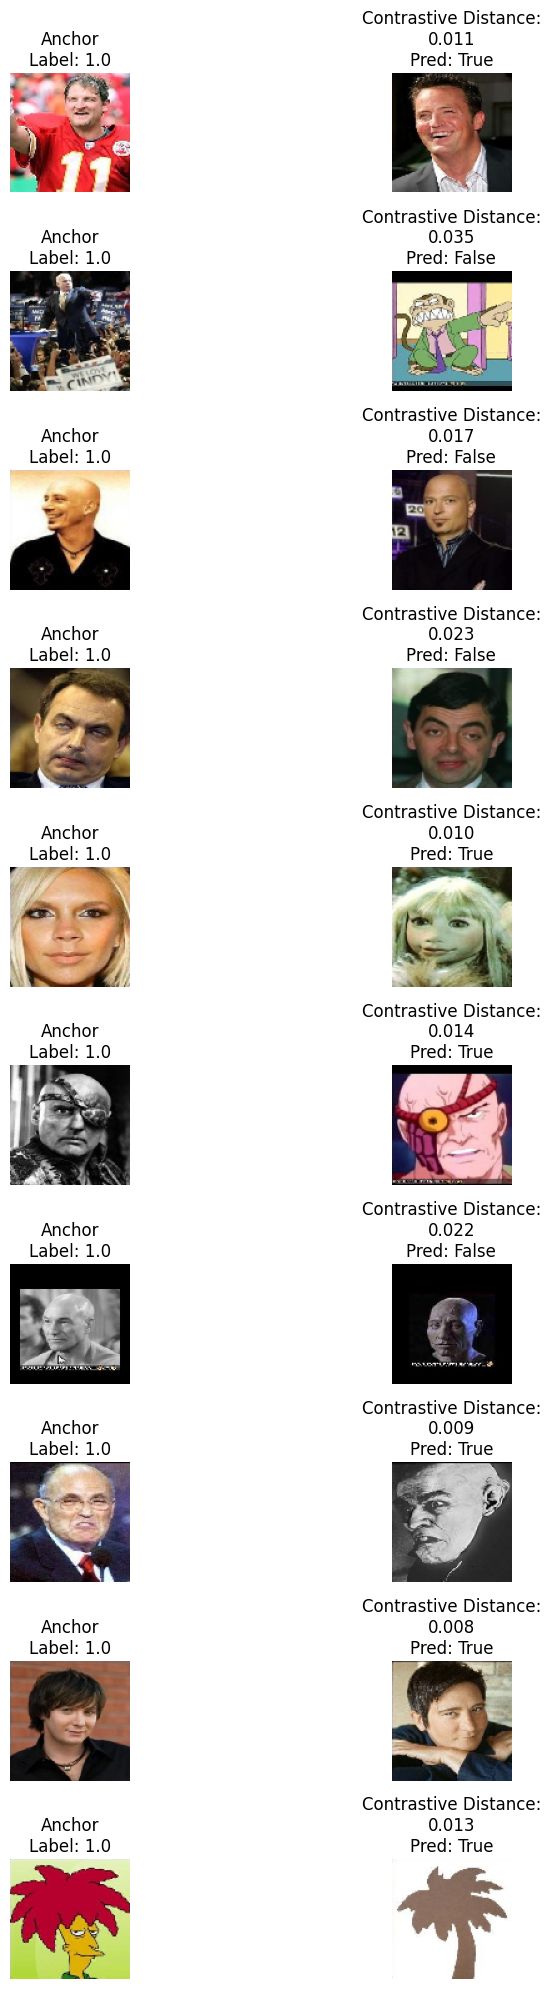

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


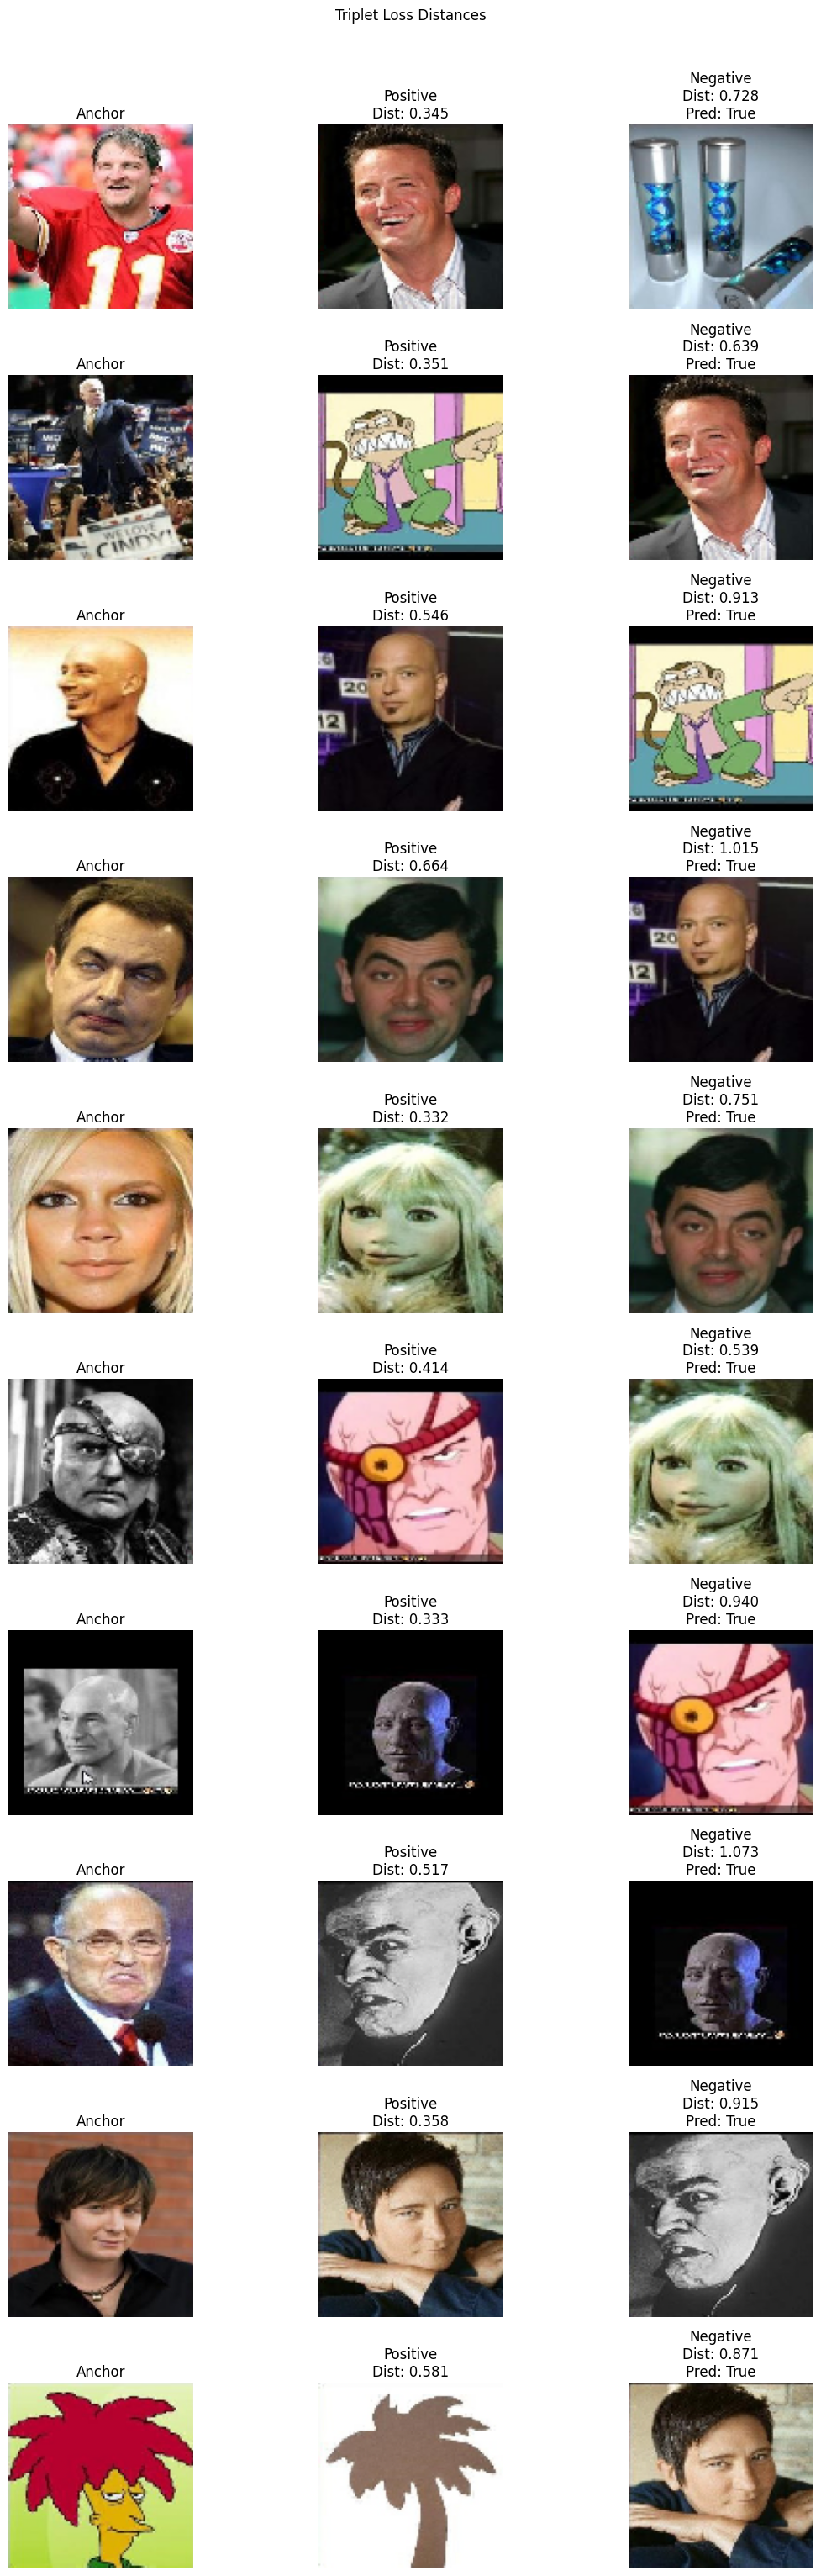

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve
import gc

# --- PARAMETERS ---
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 5

# --- LOAD IMAGES ---
def load_images_from_path(path, img_size=IMG_SIZE):
    images = []
    files = sorted(list(path.glob('*')))
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

left_imgs = load_images_from_path(Path("Data/left"))
right_imgs = load_images_from_path(Path("Data/right"))

# Limit size for fast debugging/training (optional)
left_imgs = left_imgs[:200]
right_imgs = right_imgs[:200]

print(f"Loaded images: left {left_imgs.shape}, right {right_imgs.shape}")

# --- CREATE NEGATIVE PAIRS ---
right_imgs_neg = np.roll(right_imgs, shift=1, axis=0)  # shifted by 1 to create negatives

# Labels for positive pairs
pos_labels = np.ones(len(left_imgs))
# Labels for negative pairs
neg_labels = np.zeros(len(left_imgs))

# --- BASE NETWORK ---
def create_base_network(input_shape):
    inp = Input(input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x)

input_shape = left_imgs.shape[1:]

tf.keras.backend.clear_session()

# --- 1. BCE MODEL ---
base_network_bce = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
feat_a = base_network_bce(input_a)
feat_b = base_network_bce(input_b)
concat = layers.concatenate([feat_a, feat_b])
output_bce = layers.Dense(1, activation='sigmoid')(concat)
model_bce = Model([input_a, input_b], output_bce)
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 2. CONTRASTIVE MODEL ---
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

base_network_contrastive = create_base_network(input_shape)
input_a2 = Input(shape=input_shape)
input_b2 = Input(shape=input_shape)
feat_a2 = base_network_contrastive(input_a2)
feat_b2 = base_network_contrastive(input_b2)
dist = layers.Lambda(euclidean_distance)([feat_a2, feat_b2])
model_contrastive = Model([input_a2, input_b2], dist)
model_contrastive.compile(optimizer='adam', loss=contrastive_loss(margin=1.0))

# --- 3. TRIPLET MODEL ---
def triplet_loss(alpha=0.2):
    def loss(y_true, y_pred):
        anchor = y_pred[:, 0:128]
        pos = y_pred[:, 128:256]
        neg = y_pred[:, 256:384]
        pos_dist = K.sum(K.square(anchor - pos), axis=1)
        neg_dist = K.sum(K.square(anchor - neg), axis=1)
        basic_loss = pos_dist - neg_dist + alpha
        return K.mean(K.maximum(basic_loss, 0.0))
    return loss

base_network_triplet = create_base_network(input_shape)
input_anchor = Input(shape=input_shape)
input_pos = Input(shape=input_shape)
input_neg = Input(shape=input_shape)
feat_anchor = base_network_triplet(input_anchor)
feat_pos = base_network_triplet(input_pos)
feat_neg = base_network_triplet(input_neg)
merged_feat = layers.concatenate([feat_anchor, feat_pos, feat_neg])
model_triplet = Model([input_anchor, input_pos, input_neg], merged_feat)
model_triplet.compile(optimizer='adam', loss=triplet_loss(alpha=0.2))

# Dummy labels for triplet (not used but needed for fit)
dummy_y = np.zeros(len(left_imgs))

# --- TRAIN BCE ---
print("\nTraining BCE model...")
model_bce.fit([left_imgs, right_imgs], pos_labels,
              batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

# --- TRAIN CONTRASTIVE ---
print("\nTraining Contrastive model...")
model_contrastive.fit([left_imgs, right_imgs], pos_labels,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

# --- TRAIN TRIPLET ---
print("\nTraining Triplet model...")
model_triplet.fit([left_imgs, right_imgs, right_imgs_neg], dummy_y,
                  batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

gc.collect()

# --- PREDICTIONS FOR THRESHOLD SELECTION ---

# BCE
pos_bce_preds = model_bce.predict([left_imgs, right_imgs]).flatten()
neg_bce_preds = model_bce.predict([left_imgs, right_imgs_neg]).flatten()
bce_all_preds = np.concatenate([pos_bce_preds, neg_bce_preds])
bce_all_labels = np.concatenate([pos_labels, neg_labels])

fpr, tpr, thresholds = roc_curve(bce_all_labels, bce_all_preds)
J = tpr - fpr
ix = np.argmax(J)
bce_best_thresh = thresholds[ix]
print(f"BCE best threshold: {bce_best_thresh:.3f}")

# Contrastive
pos_contrastive_preds = model_contrastive.predict([left_imgs, right_imgs]).flatten()
neg_contrastive_preds = model_contrastive.predict([left_imgs, right_imgs_neg]).flatten()

# For distances, smaller means positive, so invert scores for ROC
contrastive_all_preds = np.concatenate([-pos_contrastive_preds, -neg_contrastive_preds])
contrastive_all_labels = np.concatenate([pos_labels, neg_labels])

fpr, tpr, thresholds = roc_curve(contrastive_all_labels, contrastive_all_preds)
J = tpr - fpr
ix = np.argmax(J)
contrastive_best_thresh = thresholds[ix]
# Since inverted, invert threshold back
contrastive_best_thresh = -contrastive_best_thresh
print(f"Contrastive best threshold: {contrastive_best_thresh:.3f}")

# Triplet
embed_anchor = base_network_triplet.predict(left_imgs)
embed_positive = base_network_triplet.predict(right_imgs)
embed_negative = base_network_triplet.predict(right_imgs_neg)

pos_dist = np.linalg.norm(embed_anchor - embed_positive, axis=1)
neg_dist = np.linalg.norm(embed_anchor - embed_negative, axis=1)
triplet_scores = pos_dist - neg_dist

triplet_all_scores = np.concatenate([triplet_scores, triplet_scores * -1])  # flip some negatives for ROC
triplet_all_labels = np.concatenate([pos_labels, neg_labels])

fpr, tpr, thresholds = roc_curve(triplet_all_labels, -triplet_all_scores)  # invert score for ROC
J = tpr - fpr
ix = np.argmax(J)
triplet_best_thresh = thresholds[ix]
triplet_best_thresh = -triplet_best_thresh
print(f"Triplet best threshold: {triplet_best_thresh:.3f}")

# --- VISUALIZATION FUNCTIONS ---
def plot_pairs_with_labels(images1, images2, labels, preds, threshold, title, invert_threshold=False):
    plt.figure(figsize=(10, 2*len(images1)))
    for i in range(len(images1)):
        pred_val = preds[i]
        if invert_threshold:
            pred_label = "True" if pred_val <= threshold else "False"
        else:
            pred_label = "True" if pred_val >= threshold else "False"
        plt.subplot(len(images1), 2, 2*i+1)
        plt.imshow(images1[i])
        plt.axis('off')
        plt.title(f"Anchor\nLabel: {labels[i]}")
        plt.subplot(len(images1), 2, 2*i+2)
        plt.imshow(images2[i])
        plt.axis('off')
        plt.title(f"{title}:\n{pred_val:.3f}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

def plot_triplets_with_labels(anchor_imgs, pos_imgs, neg_imgs, pos_dists, neg_dists, threshold, title):
    plt.figure(figsize=(12, 3*len(anchor_imgs)))
    for i in range(len(anchor_imgs)):
        triplet_score = pos_dists[i] - neg_dists[i]
        pred_label = "True" if triplet_score < threshold else "False"
        plt.subplot(len(anchor_imgs), 3, 3*i+1)
        plt.imshow(anchor_imgs[i])
        plt.axis('off')
        plt.title('Anchor')
        plt.subplot(len(anchor_imgs), 3, 3*i+2)
        plt.imshow(pos_imgs[i])
        plt.axis('off')
        plt.title(f'Positive\nDist: {pos_dists[i]:.3f}')
        plt.subplot(len(anchor_imgs), 3, 3*i+3)
        plt.imshow(neg_imgs[i])
        plt.axis('off')
        plt.title(f'Negative\nDist: {neg_dists[i]:.3f}\nPred: {pred_label}')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# --- VISUALIZE PREDICTIONS ---

sample_idx = list(range(min(10, len(left_imgs))))
left_sample = left_imgs[sample_idx]
right_sample = right_imgs[sample_idx]
neg_sample = right_imgs_neg[sample_idx]
labels_sample = pos_labels[sample_idx]

# BCE visualization
bce_preds_sample = model_bce.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, bce_preds_sample, bce_best_thresh, "BCE Prediction Probability")

# Contrastive visualization
contrastive_preds_sample = model_contrastive.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, contrastive_preds_sample, contrastive_best_thresh, "Contrastive Distance", invert_threshold=True)

# Triplet visualization
embed_anchor_s = base_network_triplet.predict(left_sample)
embed_positive_s = base_network_triplet.predict(right_sample)
embed_negative_s = base_network_triplet.predict(neg_sample)

pos_dist_s = np.linalg.norm(embed_anchor_s - embed_positive_s, axis=1)
neg_dist_s = np.linalg.norm(embed_anchor_s - embed_negative_s, axis=1)

plot_triplets_with_labels(left_sample, right_sample, neg_sample, pos_dist_s, neg_dist_s, triplet_best_thresh, "Triplet Loss Distances")


2025-07-22 19:54:47.938990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 19:54:47.939090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 19:54:48.039447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 19:54:48.234659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 19:54:49.682547: W tensorflow/compiler/tf2

Full dataset contains 6016 left images and 6016 right images.
Using a limited dataset of 500 image pairs to prevent crashing.

--- Starting Model Training ---

Training BCE model...
Epoch 1/5


2025-07-22 19:55:04.439725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-22 19:55:04.937273: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


25/25 - 4s - 163ms/step - accuracy: 0.9875 - loss: 0.2955 - val_accuracy: 1.0000 - val_loss: 0.2364
Epoch 2/5
25/25 - 5s - 193ms/step - accuracy: 1.0000 - loss: 0.2076 - val_accuracy: 1.0000 - val_loss: 0.1797
Epoch 3/5
25/25 - 3s - 115ms/step - accuracy: 1.0000 - loss: 0.1584 - val_accuracy: 1.0000 - val_loss: 0.1382
Epoch 4/5
25/25 - 5s - 201ms/step - accuracy: 1.0000 - loss: 0.1230 - val_accuracy: 1.0000 - val_loss: 0.1086
Epoch 5/5
25/25 - 3s - 118ms/step - accuracy: 1.0000 - loss: 0.0975 - val_accuracy: 1.0000 - val_loss: 0.0871

Training Contrastive model...
Epoch 1/5
50/50 - 6s - 130ms/step - loss: 0.2434 - val_loss: 0.3104
Epoch 2/5
50/50 - 6s - 113ms/step - loss: 0.2123 - val_loss: 0.3748
Epoch 3/5
50/50 - 6s - 112ms/step - loss: 0.2025 - val_loss: 0.3743
Epoch 4/5
50/50 - 6s - 113ms/step - loss: 0.1828 - val_loss: 0.3466
Epoch 5/5
50/50 - 6s - 114ms/step - loss: 0.1556 - val_loss: 0.2976

Training Triplet model...
Epoch 1/5
25/25 - 5s - 200ms/step - loss: 0.1869 - val_loss: 0

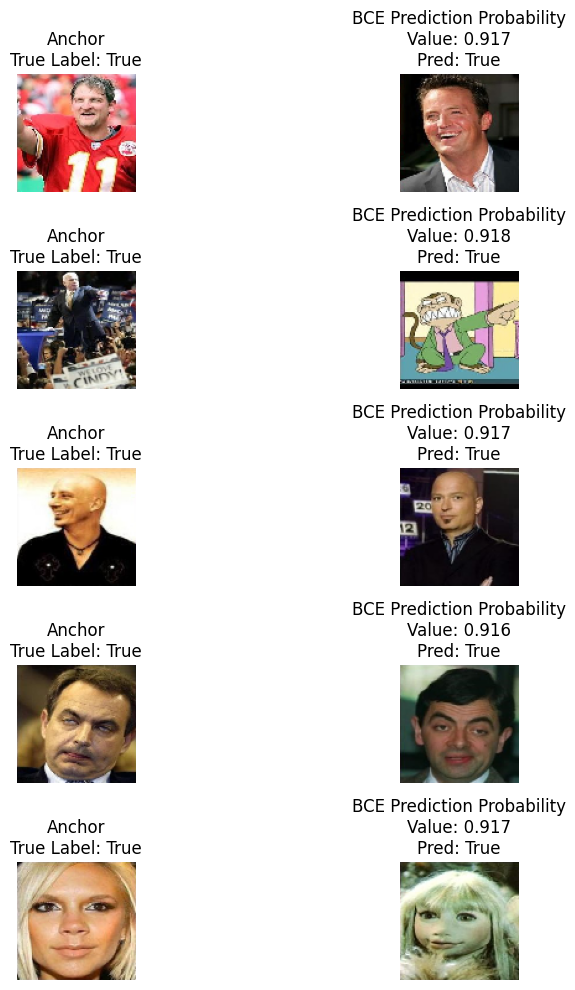

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


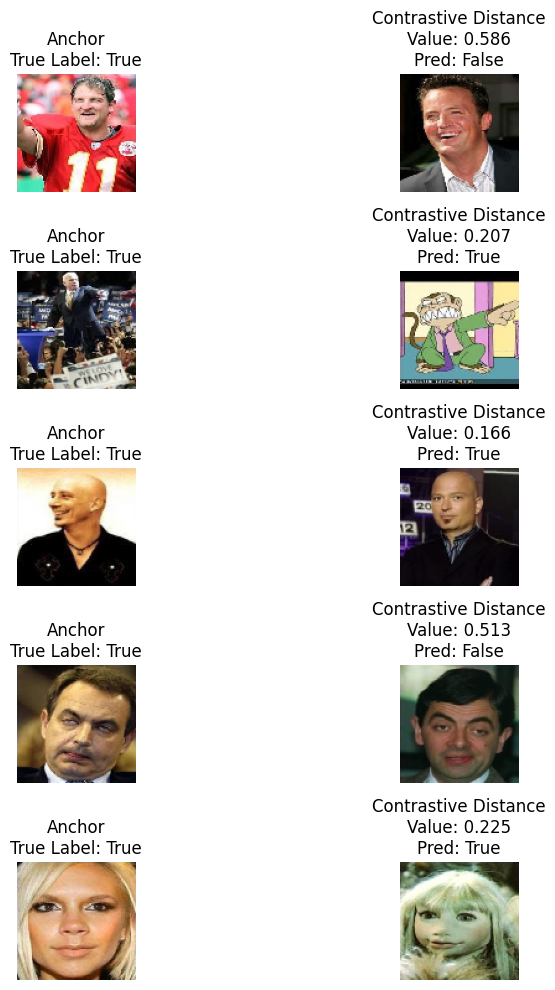

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


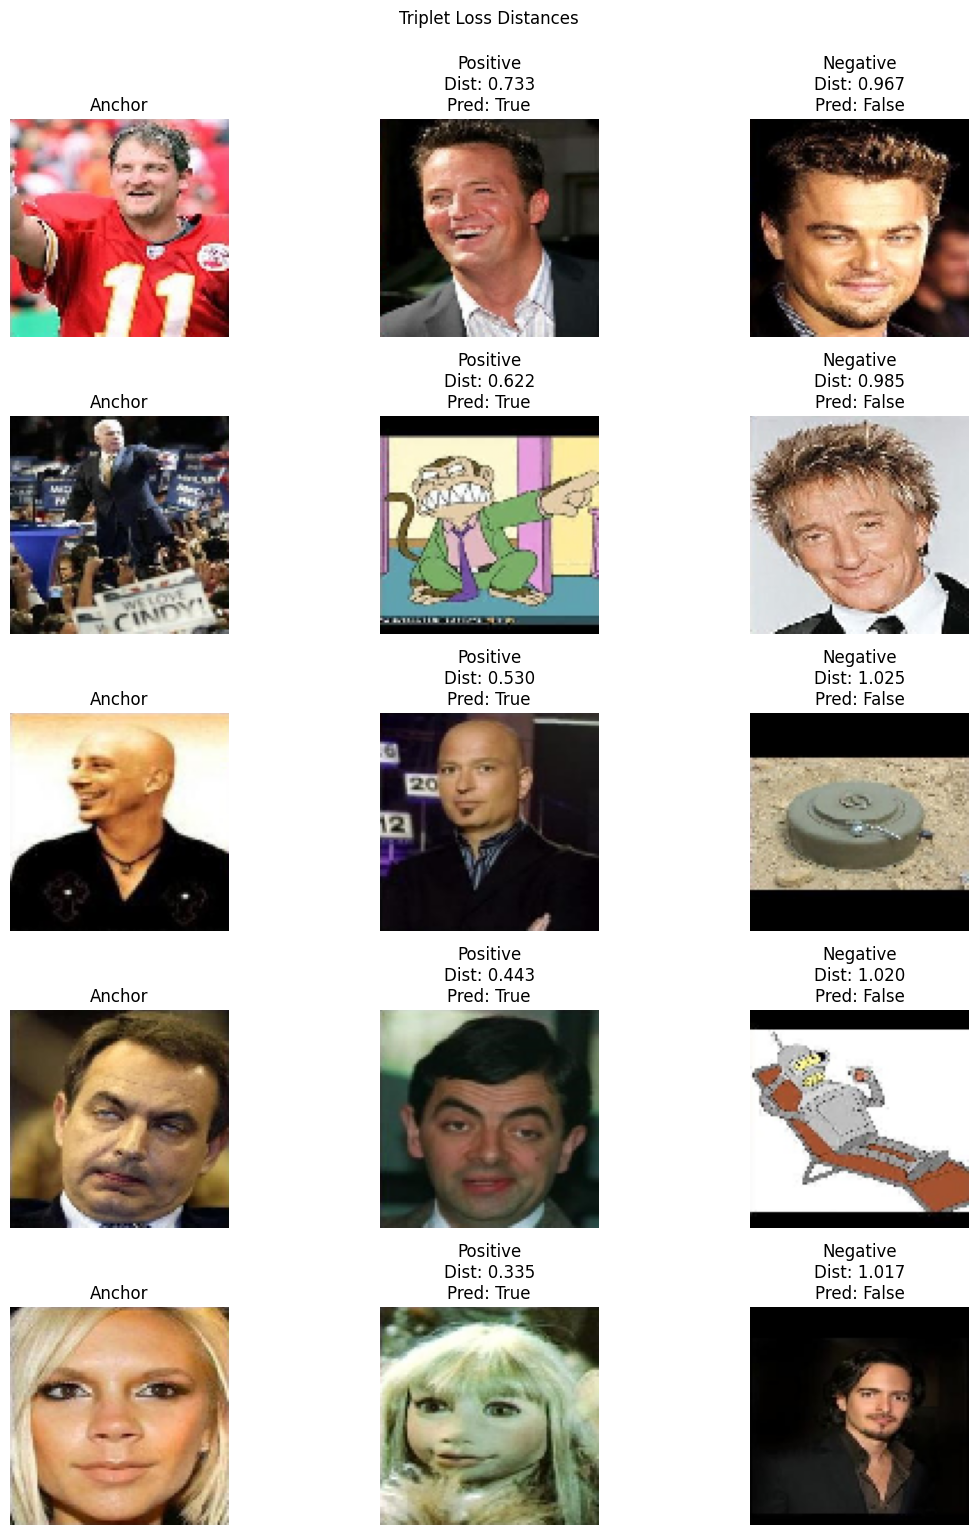

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve
import gc
import os

# --- PARAMETERS ---
IMG_SIZE = (96, 96)
BATCH_SIZE = 16  # Reduced batch size to further save memory
EPOCHS = 5
MARGIN = 1.0
ALPHA = 0.2

# --- !! ADJUST THIS TO PREVENT CRASHES !! ---
# Sets the maximum number of image pairs to load.
# Start with a small number like 500 or 1000. Increase it if your PC can handle it.
DATASET_SIZE_LIMIT = 500 

# --- LOAD IMAGES ---
def load_images_from_path(path, img_size=IMG_SIZE):
    """Loads images from a directory, resizes them, and normalizes them."""
    images = []
    # Make sure the directory exists to avoid errors
    if not path.exists():
        print(f"Error: Directory not found at {path}")
        return np.array(images)
    files = sorted(list(path.glob('*')))
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

# Load the image data from the specified paths
# Ensure you have a "Data/left" and "Data/right" directory with images.
left_imgs_full = load_images_from_path(Path("Data/left"))
right_imgs_full = load_images_from_path(Path("Data/right"))

# --- !! DATASET REDUCTION TO PREVENT CRASHING !! ---
if len(left_imgs_full) == 0 or len(right_imgs_full) == 0:
    print("\n---")
    print("Error: No images were loaded. Please ensure the 'Data/left' and 'Data/right' directories exist and contain images.")
    print("Exiting script.")
    print("---\n")
    exit()

# Limit the dataset size based on the parameter
limit = min(DATASET_SIZE_LIMIT, len(left_imgs_full), len(right_imgs_full))
left_imgs = left_imgs_full[:limit]
right_imgs = right_imgs_full[:limit]

print(f"Full dataset contains {len(left_imgs_full)} left images and {len(right_imgs_full)} right images.")
print(f"Using a limited dataset of {len(left_imgs)} image pairs to prevent crashing.")

# --- CREATE NEGATIVE PAIRS ---
right_imgs_neg = np.copy(right_imgs)
np.random.shuffle(right_imgs_neg)

pos_labels = np.ones(len(left_imgs))
neg_labels = np.zeros(len(left_imgs))

# --- BASE NETWORK ---
def create_base_network(input_shape):
    """Creates the base convolutional network for feature extraction."""
    inp = Input(input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x, name="base_network")

input_shape = left_imgs.shape[1:]

tf.keras.backend.clear_session()

# --- 1. BINARY CROSS-ENTROPY (BCE) MODEL ---
base_network_bce = create_base_network(input_shape)
input_a = Input(shape=input_shape, name="input_a")
input_b = Input(shape=input_shape, name="input_b")
feat_a = base_network_bce(input_a)
feat_b = base_network_bce(input_b)
concat = layers.concatenate([feat_a, feat_b])
output_bce = layers.Dense(1, activation='sigmoid')(concat)
model_bce = Model([input_a, input_b], output_bce)
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 2. CONTRASTIVE MODEL ---
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(margin=MARGIN):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

base_network_contrastive = create_base_network(input_shape)
input_a2 = Input(shape=input_shape, name="input_a2")
input_b2 = Input(shape=input_shape, name="input_b2")
feat_a2 = base_network_contrastive(input_a2)
feat_b2 = base_network_contrastive(input_b2)
dist = layers.Lambda(euclidean_distance)([feat_a2, feat_b2])
model_contrastive = Model([input_a2, input_b2], dist)
model_contrastive.compile(optimizer='adam', loss=contrastive_loss())

# --- 3. TRIPLET MODEL ---
def triplet_loss(alpha=ALPHA):
    def loss(y_true, y_pred):
        anchor = y_pred[:, 0:128]
        pos = y_pred[:, 128:256]
        neg = y_pred[:, 256:384]
        pos_dist = K.sum(K.square(anchor - pos), axis=1)
        neg_dist = K.sum(K.square(anchor - neg), axis=1)
        basic_loss = pos_dist - neg_dist + alpha
        return K.mean(K.maximum(basic_loss, 0.0))
    return loss

base_network_triplet = create_base_network(input_shape)
input_anchor = Input(shape=input_shape, name="anchor")
input_pos = Input(shape=input_shape, name="positive")
input_neg = Input(shape=input_shape, name="negative")
feat_anchor = base_network_triplet(input_anchor)
feat_pos = base_network_triplet(input_pos)
feat_neg = base_network_triplet(input_neg)
merged_feat = layers.concatenate([feat_anchor, feat_pos, feat_neg])
model_triplet = Model([input_anchor, input_pos, input_neg], merged_feat)
model_triplet.compile(optimizer='adam', loss=triplet_loss())

dummy_y = np.zeros(len(left_imgs))

# --- TRAIN MODELS ---
print("\n--- Starting Model Training ---")

print("\nTraining BCE model...")
model_bce.fit([left_imgs, right_imgs], pos_labels,
              batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)
gc.collect() # Force garbage collection to free up memory

print("\nTraining Contrastive model...")
x_contrastive = [np.concatenate([left_imgs, left_imgs]), np.concatenate([right_imgs, right_imgs_neg])]
y_contrastive = np.concatenate([pos_labels, neg_labels])
model_contrastive.fit(x_contrastive, y_contrastive,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)
gc.collect()

print("\nTraining Triplet model...")
model_triplet.fit([left_imgs, right_imgs, right_imgs_neg], dummy_y,
                  batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)
gc.collect()

print("\n--- Model Training Complete ---")


# --- PREDICTIONS AND THRESHOLDING ---
print("\n--- Calculating Optimal Thresholds ---")

# BCE Threshold
pos_bce_preds = model_bce.predict([left_imgs, right_imgs]).flatten()
neg_bce_preds = model_bce.predict([left_imgs, right_imgs_neg]).flatten()
bce_all_preds = np.concatenate([pos_bce_preds, neg_bce_preds])
bce_all_labels = np.concatenate([pos_labels, neg_labels])
fpr, tpr, thresholds = roc_curve(bce_all_labels, bce_all_preds)
J = tpr - fpr
ix = np.argmax(J)
bce_best_thresh = thresholds[ix]
print(f"BCE best threshold: {bce_best_thresh:.3f}")

# Contrastive Threshold
pos_contrastive_dists = model_contrastive.predict([left_imgs, right_imgs]).flatten()
neg_contrastive_dists = model_contrastive.predict([left_imgs, right_imgs_neg]).flatten()
contrastive_all_dists = np.concatenate([pos_contrastive_dists, neg_contrastive_dists])
contrastive_all_labels = np.concatenate([pos_labels, neg_labels])
fpr, tpr, thresholds = roc_curve(contrastive_all_labels, -contrastive_all_dists)
J = tpr - fpr
ix = np.argmax(J)
contrastive_best_thresh = -thresholds[ix]
print(f"Contrastive best threshold: {contrastive_best_thresh:.3f}")

# Triplet Threshold
embed_anchor = base_network_triplet.predict(left_imgs)
embed_positive = base_network_triplet.predict(right_imgs)
embed_negative = base_network_triplet.predict(right_imgs_neg)
pos_triplet_dists = np.linalg.norm(embed_anchor - embed_positive, axis=1)
neg_triplet_dists = np.linalg.norm(embed_anchor - embed_negative, axis=1)
triplet_all_dists = np.concatenate([pos_triplet_dists, neg_triplet_dists])
triplet_all_labels = np.concatenate([pos_labels, neg_labels])
fpr, tpr, thresholds = roc_curve(triplet_all_labels, -triplet_all_dists)
J = tpr - fpr
ix = np.argmax(J)
triplet_best_thresh = -thresholds[ix]
print(f"Triplet best threshold: {triplet_best_thresh:.3f}")


# --- VISUALIZATION FUNCTIONS ---
def plot_pairs_with_labels(images1, images2, labels, preds, threshold, title, is_distance=False):
    plt.figure(figsize=(10, 2 * len(images1)))
    for i in range(len(images1)):
        pred_val = preds[i]
        if is_distance:
            pred_label = "True" if pred_val <= threshold else "False"
        else:
            pred_label = "True" if pred_val >= threshold else "False"
        plt.subplot(len(images1), 2, 2 * i + 1)
        plt.imshow(images1[i])
        plt.axis('off')
        plt.title(f"Anchor\nTrue Label: {bool(labels[i])}")
        plt.subplot(len(images1), 2, 2 * i + 2)
        plt.imshow(images2[i])
        plt.axis('off')
        plt.title(f"{title}\nValue: {pred_val:.3f}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

def plot_triplets_with_labels(anchor_imgs, pos_imgs, neg_imgs, pos_dists, neg_dists, threshold, title):
    plt.figure(figsize=(12, 3 * len(anchor_imgs)))
    for i in range(len(anchor_imgs)):
        pos_pred_label = "True" if pos_dists[i] <= threshold else "False"
        neg_pred_label = "True" if neg_dists[i] <= threshold else "False"
        plt.subplot(len(anchor_imgs), 3, 3 * i + 1)
        plt.imshow(anchor_imgs[i]); plt.axis('off'); plt.title('Anchor')
        plt.subplot(len(anchor_imgs), 3, 3 * i + 2)
        plt.imshow(pos_imgs[i]); plt.axis('off'); plt.title(f'Positive\nDist: {pos_dists[i]:.3f}\nPred: {pos_pred_label}')
        plt.subplot(len(anchor_imgs), 3, 3 * i + 3)
        plt.imshow(neg_imgs[i]); plt.axis('off'); plt.title(f'Negative\nDist: {neg_dists[i]:.3f}\nPred: {neg_pred_label}')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# --- VISUALIZE PREDICTIONS ---
print("\n--- Visualizing Sample Predictions ---")

sample_idx = list(range(min(5, len(left_imgs))))
left_sample = left_imgs[sample_idx]
right_sample = right_imgs[sample_idx]
neg_sample = right_imgs_neg[sample_idx]
labels_sample = pos_labels[sample_idx]

# BCE visualization
bce_preds_sample = model_bce.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, bce_preds_sample, bce_best_thresh, "BCE Prediction Probability", is_distance=False)

# Contrastive visualization
contrastive_preds_sample = model_contrastive.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, contrastive_preds_sample, contrastive_best_thresh, "Contrastive Distance", is_distance=True)

# Triplet visualization
embed_anchor_s = base_network_triplet.predict(left_sample)
embed_positive_s = base_network_triplet.predict(right_sample)
embed_negative_s = base_network_triplet.predict(neg_sample)
pos_dist_s = np.linalg.norm(embed_anchor_s - embed_positive_s, axis=1)
neg_dist_s = np.linalg.norm(embed_anchor_s - embed_negative_s, axis=1)
plot_triplets_with_labels(left_sample, right_sample, neg_sample, pos_dist_s, neg_dist_s, triplet_best_thresh, "Triplet Loss Distances")